In [599]:
import time
start = time.time()

In [600]:
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import copy

In [601]:
#parameters
interval=15 #time window
maxDelta=3 #how many delta
th=0.5 #distance
window_size=4 #window size
support=0.01
support_str="001"

In [602]:
#FILES
inputPath  = "file:///home/bigdata-01QYD/s270240/bike_sharing/filtered_status.csv"
STATION_PATH="file:///home/bigdata-01QYD/s270240/bike_sharing/station.csv"
#save file of first filter
output_file=f'./Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support_str}({window_size}-{maxDelta})/results_{int(th*1000)}_{support_str}_ordered_by_confidence.txt'
# output_file2=f'../Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta})/results_{int(th*1000)}_{support}_QuasiVuota_Vuota_ordered_by_confidence.txt'
# output_file3=f'../Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta})/results_{int(th*1000)}_{support}_diff_delta_ordered_by_confidence.txt'
output_file4=f'./Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support_str}({window_size}-{maxDelta})/results_{int(th*1000)}_{support_str}_ordered_by_support.txt'
# output_file5=f'../Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta})/results_{int(th*1000)}_{support}_QuasiVuota_Vuota_ordered_by_support.txt'
# output_file6=f'../Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support}({window_size}-{maxDelta})/results_{int(th*1000)}_{support}_diff_delta_ordered_by_support.txt'
img_support=f'./Results_extraction/StateChange_Full_almostFull/StateChange_Full_almostFull_{interval}_{int(th*1000)}_{support_str}({window_size}-{maxDelta})/{window_size}-{maxDelta}-{int(th*1000)}-{support_str}.jpg'



In [603]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [604]:
inputDF=inputDF.filter("docks_available is not null")

In [605]:
#filter for these fields
filteredDF = inputDF.filter("docks_available<>0 OR bikes_available<>0")

In [606]:
#determine if the station is full or almost full
def stateFunction(docks_available,bikes_available):
    if docks_available==0:
        return 1
    elif (docks_available==1 or docks_available==2):
        return 0
    else:
        return 2

In [607]:
spark.udf.register("state", stateFunction)

<function __main__.stateFunction(docks_available, bikes_available)>

In [608]:
def getInt(station):
    return (station)

In [609]:
spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [610]:
getStatusDF = filteredDF.selectExpr("station_id","time", "state(docks_available,bikes_available) as status")

In [611]:
# getStatusDF.show(100,False)

In [612]:
#create a view
getStatusDF.createOrReplaceTempView("readings")

In [613]:
#select station, year, month, day, hour, minute, status ordered by time
ss=spark.sql("""SELECT  station_id , YEAR(time) as year, MONTH(time) as month, DAY(time) as day, HOUR(time)as hour, MINUTE(time) as minute, status
FROM readings
GROUP BY station_id, year, month, day,hour,minute, status
ORDER BY  station_id,year, month,day, hour,minute
""")

In [614]:
#create rdd and group into interval
my_rdd=ss.rdd.map(tuple)
rdd=my_rdd.map(lambda line: (line[0],line[1],line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()

In [615]:
# rdd.collect()

# [(6, 2013, 12, 31, 1, 1, '2'),
#  (6, 2014, 1, 14, 22, 1, '2'),
#  (6, 2014, 1, 16, 0, 1, '2'),
#  (6, 2014, 1, 19, 6, 0, '2'),
#  (6, 2014, 1, 23, 21, 1, '2'),
#  (6, 2014, 1, 26, 10, 1, '2'),
#  (6, 2014, 1, 30, 14, 1, '2'), ... ]

In [616]:
#get distinct stations to calculate distances
id_stations=rdd.map(lambda line: line[0]).distinct()

In [617]:
tot_id_stations=id_stations.collect()

In [618]:
#obtain timestamp and info
def getMap2(line):
    id_station=str(line[0])
    year=int(line[1])
    month=int(line[2])
    day=int(line[3])
    hour=int(line[4])
    minute=int(line[5])   
    timestamp= datetime(year,month, day, hour, minute)  
    status=int(line[6])
    info=str(id_station)+' '+str(status)
    return (timestamp, info)

In [619]:
get_map2=rdd.map(getMap2)

In [620]:
# get_map2.collect()

# [(datetime.datetime(2014, 3, 31, 18, 1), '11 2'),
#  (datetime.datetime(2014, 4, 6, 21, 0), '11 2'),
#  (datetime.datetime(2014, 4, 10, 22, 1), '11 2'),
#  (datetime.datetime(2014, 4, 12, 8, 1), '11 2'),
#  (datetime.datetime(2014, 4, 13, 8, 0), '11 2'), ... ]

In [621]:
reduceK2=get_map2.reduceByKey(lambda l1,l2 :(l1+','+l2)).sortByKey()

In [622]:
# reduceK2.collect()

# [(datetime.datetime(2013, 8, 29, 10, 0), '59 0,67 0,4 1,13 1,67 1,6 0,2 0,7 1,16 0,70 1,70 0'),
#  (datetime.datetime(2013, 8, 29, 10, 1), '67 0,7 1,16 0,59 0,13 1,67 1,70 0,2 0,7 0,69 0,4 1,13 0,73 0'),
#  (datetime.datetime(2013, 8, 29, 11, 0), '67 1,2 0,4 0,73 0,67 0,69 0,16 0,70 0,4 1'),
#  (datetime.datetime(2013, 8, 29, 11, 1), '16 0,73 0,2 0,69 0,67 0'),
#  (datetime.datetime(2013, 8, 29, 12, 0), '69 1,69 0,16 0,2 0,73 0'), ... ]

In [623]:
list_tot=reduceK2.collect()

In [624]:
# list_tot[:5]

In [625]:
voc_status={}
voc_timestamp={}
list_filtered=[]

voc_tmp={}

# previous_list=[]
# updated_list=[]

for i, el in enumerate(list_tot):
    #updated_list=[]    
    information=el[1]   
    tmp_list_station='' 
    voc_tmp={}
    
    for info in information.split(','):
#         print()
#         print(info)
        station=str(info.split(' ')[0])
            
        status=int(info.split(' ')[1])
        if  station not in voc_status:
#             print (f"station: {station} NOT PRESENT")
            voc_status[station]=status
            tmp_time= el[0].replace(minute=el[0].minute*interval) #riconverto nei minuti originali 
            voc_timestamp[station]=tmp_time
#             print (f"actual_time: {voc_timestamp[station]}")
            stringa=''
            if status==0:
                stringa='QuasiPiena'
            elif status == 1:
                stringa='Piena'
            else:
                stringa='Normal'    
            tmp_list_station+=','+station+'_'+ stringa 
#             print(tmp_list_station)
            #updated_list.append(station)
                  
        else:
#             print (f"station: {station} PRESENT")
            times=voc_timestamp[station]
#             print (f"times: {times}")
            tmp_time= el[0].replace(minute=el[0].minute*interval) #riconverto nei minuti originali
            actual_time=tmp_time
#             print (f"actual_time: {actual_time}")
#             print (f"old satus: {voc_status[station]}")
#             print (f"new satus: {status}")
            
            if times == actual_time:    #inside same timeslot
                if status != voc_status[station]:   # if status changed   
#                     print("STATUS CHANGED INSIDE THE SAME TIMESLOT!!!!!")
                    voc_status[station]=3  #set flag of status changed inside same timeslot
                    stringa=''
                    if status==0:
                        stringa='QuasiPiena'
                    elif status == 1:
                        stringa='Piena'
                    else:
                        stringa='Normal'    
                    tmp_list_station+=','+station+'_'+ stringa 
#                     print(tmp_list_station)
                    
            else:            # different timeslot
#                 print(f"actual_time.minute-times.minute: {int((actual_time-times).total_seconds() / 60.0)}")
#                 if ((actual_time.hour == times.hour and actual_time.minute-times.minute==1) or
#                     (actual_time.hour-times.hour==1 and actual_time.minute-times.minute==-1)):
                
                if (int((actual_time-times).total_seconds() / 60.0)== interval): # after less than 30 minutes
#                     print(f"after <= 30 minutes")
                    if voc_status[station]==3:         #if status changed inside the same old timeslot        
#                         print("STATUS CHANGED INSIDE THE SAME OLD TIMESLOT!!!!!")
                        voc_status[station]=status     #update old status with new one
                        voc_timestamp[station]=actual_time      #update old timestamp with new one
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        elif status==1 :
                            stringa='Piena'
                        else:
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                        #updated_list.append(station)
                        
                    elif voc_status[station] != status:  # if status changed between old and new timeslot 
#                         print("STATUS CHANGED!!!!!")
                        voc_status[station]=status     #update old status with new one
                        voc_timestamp[station]=actual_time    #update old timestamp with new one
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        elif status == 1:
                            stringa='Piena'
                        else :
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                        
                        if station in voc_tmp:
                            if voc_tmp[station]==1:
                                 tmp_list_station+=','+station+'_Piena'
                            elif voc_tmp[station]==0:
                                 tmp_list_station+=','+station+'_QuasiPiena'
                            elif voc_tmp[station]==2:
                                 tmp_list_station+=','+station+'_Normal'
                            
#                             print(tmp_list_station)
                        
                        
                    elif  voc_status[station] == status: # if status did not change between old and new timeslot
#                         print("STATUS DID NOT CHANGE!!!!!")
                        voc_tmp[station]=status
                        tmp_list_station+=','+station+'_NoChange'
#                         print(tmp_list_station)
#                         voc_timestamp[station]=actual_time     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                    
                # after more than 30 minutes        
                else:
#                     print(f"after >= 30 minutes")
                    if voc_status[station] != status:
                        stringa=''
                        if status==0:
                            stringa='QuasiPiena'
                        elif status == 1:
                            stringa='Piena'
                        else :
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                    else:
                        tmp_list_station+=','+station+'_NoChange'
#                     print (f"REMOVING STATION {station}")    
#                     del voc_status[station]
#                     del voc_timestamp[station]
                    voc_timestamp[station]=actual_time
           
        
#     if i!=0:
#         #previous_list=set(previous_list)
#         updated_list=set(updated_list)

#         for st in previous_list:
#             if st not in updated_list:              
#                 voc_status.pop(st)  
#                 voc_timestamp.pop(st)
                
            
#     previous_list=updated_list
#     updated_list=[]
    
    list_filtered.append((el[0],tmp_list_station[1::]))

In [626]:
reduceK=spark.sparkContext.parallelize(list_filtered)


In [627]:
# reduceK.collect()

In [628]:
my_df=reduceK.toDF()
#my_df.collect()

In [629]:
my_df.createOrReplaceTempView("view")

In [630]:
s2=spark.sql("""SELECT ROW_NUMBER() OVER(ORDER BY _1,_2) as id ,_1, _2
FROM view """)

In [631]:
#identifier of the timestamp, info
rdd_scheme=s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))

In [632]:
# rdd_scheme.collect()

In [633]:
#obtain window, station-status
def giveSplit(line):   
    id_window=( int(line[0] ))
    lista=[]    
    counter=id_window    
    while counter>=1:
        lista.append(('Window '+str(counter),(line[1])))
        counter=counter-1
        if (id_window-counter)==window_size:
            return lista  
    return lista

In [634]:
mapData=rdd_scheme.flatMap(giveSplit)

In [635]:
# mapData.collect()

In [636]:
filteredD=mapData.filter(lambda line: line[1]!='')

In [637]:
# filteredD.collect()

In [638]:
# for each window get all info
all_keys=filteredD.reduceByKey(lambda l1,l2:(l1+'-'+l2))

In [639]:
# all_keys.collect()

In [640]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

In [641]:
windows=all_keys.flatMap(reduceKeys)

In [642]:
# windows.collect()

In [643]:
#filtering Normal events
def filterNormal(line):
    complete_list = []
    for list_el in line[1]:
        event_list = copy.deepcopy(list_el)
        for el in list_el:
            if "Normal" in el or "NoChange"in el:
                event_list.remove(el)
#         new_event_list = ",".join(event_list)
        complete_list.append(event_list)
    return (line[0], complete_list)

In [644]:
#remove normal and noChange events

windows_withoutNormal = windows.map(filterNormal)
# windows_withoutNormal.collect()

# [('Window 1',
#   [[],
#    ['60_T1_QuasiPiena', '64_T1_QuasiPiena', '45_T1_Piena', '45_T1_QuasiPiena'],
#    ['45_T2_Piena', '64_T2_Piena', '64_T2_QuasiPiena', '45_T2_QuasiPiena']]),
#  ('Window 2',
#   [['60_T0_QuasiPiena', '64_T0_QuasiPiena', '45_T0_Piena', '45_T0_QuasiPiena'],
#    ['45_T1_Piena', '64_T1_Piena', '64_T1_QuasiPiena', '45_T1_QuasiPiena'],
#    ['64_T2_QuasiPiena', '35_T2_QuasiPiena']]),... ]

In [645]:
#filtering empty list ''
def filterEmptyList(line):
    filtered_list = list(filter(None, line[1]))
    return (line[0], filtered_list)

In [646]:
filtered_windows = windows_withoutNormal.map(filterEmptyList)
# filtered_windows.collect()

In [647]:
#filtering empty window
filtered_windows2 = filtered_windows.filter(lambda line: line[1])
# filtered_windows2.collect()

In [648]:
#save station file
stationsDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [649]:
#get only rows interested: only the used stations 
necessary_rows=stationsDF.filter(F.col("id").isin(tot_id_stations)).sort("id").rdd.map(tuple)

In [650]:
#necessary_rows.collect()

In [651]:
#get info of stations about coordinates and name
coordinates=necessary_rows.map(lambda line: (line[0],(str(line[2])+','+str(line[3]))))
names_stations=necessary_rows.map(lambda line: (line[0],line[1]))

In [652]:
list_coo=coordinates.collect()

In [653]:
# list_coo

# [(2, '37.329732,-121.90178200000001'),
#  (3, '37.330698,-121.888979'),
#  (4, '37.333988,-121.894902'),
#  (5, '37.331415,-121.8932'),
#  (6, '37.336721000000004,-121.894074'), ...]

In [654]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co=coordinates.collectAsMap()
dic_coordinates=sc.broadcast(dic_co)
#dic_coordinates.value[1]

In [655]:
#function to retrieve distance between 2 stations
def getDistance(station1,station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split(',')[0])
    lat_b=float(station2.split(',')[0])
    long_a=float(station1.split(',')[1])
    long_b=float(station2.split(',')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [656]:
#voc in which the key is a pair of stations and value is the distance
voc_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        voc_distances[id_stations]=distance

In [657]:
# voc_distances['2 3']

In [658]:
# # average distance between stations
# avg_distance=0
# for dist in voc_distances.values():
#     avg_distance+=dist
# avg_distance=avg_distance/len(voc_distances)
# #avg_distance

In [659]:
# avg_distance_float=float("{:.2f}".format(avg_distance))
# print(f'The average distance is {avg_distance_float} Km')

In [660]:
# set_all_stations=set()
# for key in voc_distances:
#     first_el=int(key.split(' ')[0])
#     second_el=int(key.split(' ')[1])
#     set_all_stations.add(first_el)
#     set_all_stations.add(second_el)

In [661]:
# # all stations that are at a distance smaller or equal to 1 km from station 1 as reference
# list_stations=[]
# count_stations=0
# reference_station=2

# for key in voc_distances:
#     first_el=int(key.split(' ')[0])
#     second_el=int(key.split(' ')[1])
#     if first_el==reference_station and voc_distances[key]<=1: 
#         count_stations+=1
#         list_stations.append(second_el)       
#     elif second_el==reference_station and voc_distances[key]<=1:
#         count_stations+=1
#         list_stations.append(first_el)

In [662]:
# list_stations

In [663]:
# for distance in [0.5,1,2,3,4,5,10,20,50,100]:
#     sum_stations=0
#     for reference_station in list(set_all_stations):
#     #     list_stations=[]
#         count_stations=0    
#         for key in voc_distances:
#             first_el=int(key.split(' ')[0])
#             second_el=int(key.split(' ')[1])
#             if first_el==reference_station and voc_distances[key]<=distance: 
#                 count_stations+=1
#     #             list_stations.append(second_el)       
#             elif second_el==reference_station and voc_distances[key]<=distance:
#                 count_stations+=1
#     #             list_stations.append(first_el)
#         sum_stations+=count_stations  
#     num_stations_Km=float("{:.2f}".format(sum_stations/len(list(set_all_stations))))
#     print(f'The average number of stations that are at a distance smaller or equal than {distance} Km is {num_stations_Km}')

In [664]:
#Applicazione “Delta Spaziale”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    #
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        act_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i,window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for all_el in window :
                #second_lista=[]
                
                act_all_el=int(all_el.split('_')[0])
                time_window= all_el.split('_')[1]
                state=all_el.split('_')[2]
               
                if act_station!=act_all_el:
                    
                    key=''
                    if act_station<act_all_el:
                        key=str(act_station)+' '+str(act_all_el)
                    else:
                        key=str(act_all_el)+' '+str(act_station)                    
                    
                    dist=voc_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        string=state+'_'+time_window+'_'+str(delta)
                        second_lista.append(string)
                else:
                    string=state+'_'+time_window+'_'+str(0)
                    second_lista.append(string)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(act_station)),list_tmp))
    
    return lista

In [665]:
spatial_app=filtered_windows2.flatMap(giveSpatialWindow)
print(spatial_app.count())

103758


In [666]:
# spatial_app.collect()

# [('Window 1|59',
#   [['QuasiVuota_T0_0', 'QuasiVuota_T0_1', 'Vuota_T0_1', 'Vuota_T0_3', 'QuasiVuota_T0_3'],
#    ['QuasiVuota_T1_1', 'Vuota_T1_1', 'QuasiVuota_T1_3', 'QuasiVuota_T1_3', 'QuasiVuota_T1_3']]),
#  ('Window 1|67',
#   [['QuasiVuota_T0_1', 'QuasiVuota_T0_0', 'Vuota_T0_0', 'Vuota_T0_2', 'QuasiVuota_T0_2'],
#    ['QuasiVuota_T1_0', 'Vuota_T1_0', 'QuasiVuota_T1_2', 'QuasiVuota_T1_2', 'QuasiVuota_T1_3']]), ...]

In [667]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

In [668]:
spatial=spatial_app.map(row_seq)

In [669]:
# spatial.collect()

In [670]:
# seq_rdd =spatial.rdd.map(tuple)
filtered_seq = spatial.filter(lambda line: "T0" in line[0][0][0])
# filtered_seq.collect()

In [671]:
#create a dataframe
df=filtered_seq.toDF()
# len(df)

In [672]:
supports=[support]

In [673]:
df.show(20,False)

+----------------------------------------------------------------------------------------+
|sequence                                                                                |
+----------------------------------------------------------------------------------------+
|[[Piena_T0_0, QuasiPiena_T0_0], [QuasiPiena_T1_3, Piena_T1_0], [QuasiPiena_T3_0]]       |
|[[Piena_T0_0, QuasiPiena_T0_0], [QuasiPiena_T1_3, Piena_T1_0], [QuasiPiena_T3_0]]       |
|[[QuasiPiena_T0_0], [QuasiPiena_T1_0], [Piena_T2_0, QuasiPiena_T2_0], [QuasiPiena_T3_0]]|
|[[QuasiPiena_T0_0, Piena_T0_3], [QuasiPiena_T2_3]]                                      |
|[[QuasiPiena_T0_3, Piena_T0_0], [QuasiPiena_T2_0]]                                      |
|[[QuasiPiena_T0_0], [Piena_T1_0, QuasiPiena_T1_0], [QuasiPiena_T2_0]]                   |
|[[Piena_T0_0, QuasiPiena_T0_0], [QuasiPiena_T1_0]]                                      |
|[[Piena_T0_0, QuasiPiena_T0_0], [QuasiPiena_T1_0]]                                      |

In [674]:
#prefixspan to obtain sequence and frequence
counter=[]
for support in supports:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    len_prefix=prefix.count()    
#     prefix.show(len_prefix,False)
    counter.append(len_prefix)

0.01


In [675]:
len_prefix

8565

In [676]:
pre=prefix.rdd.map(tuple)

In [677]:
# pre.collect()

# [([['QuasiPiena_T0_1']], 22981),
#  ([['Piena_T1_1']], 9208),
#  ([['QuasiPiena_T2_1']], 21641),
#  ([['Piena_T2_2']], 12794),
#  ([['QuasiPiena_T2_3']], 18047),
#  ([['Piena_T2_3']], 6994),
#  ([['Piena_T1_0']], 17930),
#  ([['QuasiPiena_T0_3']], 18099), ... ]

In [678]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

In [679]:
giveT0=pre.filter(giveSelected)

In [ ]:
giveT0.collect()

#CONFIGURAZIONE 30min, 1000m, 0supp, (3,3)
# [([['Piena_T0_0']], 27725),
#  ([['QuasiPiena_T0_0']], 65946),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 16609),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 17943),

#CONFIGURAZIONE 30min, 1000m, 0supp, (4,3)
# fallisce..

#CONFIGURAZIONE 30min, 1000m, 0.01supp, (4,3)
# fallisce..

#CONFIGURAZIONE 30min, 1000m, 0.02supp, (4,3)
# [([['QuasiPiena_T0_0']], 65999),
#  ([['Piena_T0_0']], 27652),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 16612),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 17845), ...]

#CONFIGURAZIONE 30min, 1000m, 0supp, (5,3)
# fallisce..

#CONFIGURAZIONE 30min, 1000m, 0.02supp, (5,3)
# [([['Piena_T0_0']], 27713),
#  ([['QuasiPiena_T0_0']], 65860),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 16615),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 17909), ... ]



#CONFIGURAZIONE 15min, 1000m, 0supp, (3,3)
# [([['QuasiPiena_T0_0']], 81559),
#  ([['Piena_T0_0']], 32958),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18557),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19778), ...]

#CONFIGURAZIONE 15min, 1000m, 0supp, (4,3)
#[([['QuasiPiena_T0_0']], 81706),
#  ([['Piena_T0_0']], 33027),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18659),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19833), ...]

#CONFIGURAZIONE 15min, 1000m, 0supp, (5,3)
# [([['QuasiPiena_T0_0']], 81742),
#  ([['Piena_T0_0']], 32997),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18662),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19797),



#CONFIGURAZIONE 15min, 500m, 0supp, (3,3)
# [([['QuasiPiena_T0_0']], 81772),
#  ([['Piena_T0_0']], 32977),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18664),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19811),

#CONFIGURAZIONE 15min, 500m, 0supp, (4,3)
# falisce...

#CONFIGURAZIONE 15min, 500m, 0.01supp, (4,3)
# [([['QuasiPiena_T0_0']], 81607),
#  ([['Piena_T0_0']], 32970),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18697),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19805),

#CONFIGURAZIONE 15min, 500m, 0supp, (5,3)
# falisce...

#CONFIGURAZIONE 15min, 500m, 0.01supp, (5,3)
# [([['QuasiPiena_T0_0']], 81573),
#  ([['Piena_T0_0']], 32837),
#  ([['QuasiPiena_T0_0'], ['Piena_T1_0']], 18548),
#  ([['Piena_T0_0'], ['QuasiPiena_T1_0']], 19703),

In [681]:
df2=giveT0.toDF().withColumnRenamed('_1','sequence')
df2=df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [682]:
#df2.show()

In [683]:
def mapValues(line):
    seq=line[0]
    final=''
    #voc[seq]=line[1]
    for i,window in enumerate(seq):
        if i>0:
            final+='-'
        for j,el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

In [684]:
mapDict=giveT0.map(mapValues)

In [685]:
# mapDict.collect()

# ['QuasiVuota_T0_0;282;0',
#  'Vuota_T0_0;192;0',
#  'QuasiVuota_T0_0,Vuota_T0_3;2;0',
#  'QuasiVuota_T0_0,Vuota_T0_3-QuasiVuota_T1_1;1;1',
#  'QuasiVuota_T0_0,Vuota_T0_3-QuasiVuota_T1_1,QuasiVuota_T1_3;1;1', ...]

In [686]:
li=mapDict.collect()
voc={}

In [687]:
for el in li:
    splits=el.split(';')
    voc[splits[0]]=int(splits[1])

In [688]:
# voc

# {'QuasiVuota_T0_0': 88948,
#  'Vuota_T0_0': 44987,
#  'Vuota_T0_0-QuasiVuota_T1_2': 33837,
#  'QuasiVuota_T0_0-Vuota_T1_0': 26011,
#  'QuasiVuota_T0_2,Vuota_T0_0': 34141, ...}

In [689]:
repeated_el_window=0
for el in voc.keys():
    flag_rep=False
    windows=el.split('-')
    for w in windows:
        tot_items=len(w.split(','))
        set_items=len(set(w.split(',')))
        if tot_items!=set_items:
            repeated_el_window+=1
            break
repeated_el_window

213

In [690]:
voc_supports={}
for el in voc.keys():    
    if len(el.split('-'))>1:        
        num=int(voc[el])       
        string=''
        tot=el.split('-')[:-1]
        for k,station in enumerate(tot):
            if k>0:
                string+='-'
            string+=station
        #print(string)
        den=int(voc[string])
        voc_supports[el]=str(num/den)+' - '+str(voc[el])
keys=list(voc_supports.keys())
values=list(voc_supports.values())

In [691]:
# voc_supports

# {'Vuota_T0_0-QuasiVuota_T1_2': '0.7521506212905951 - 33837',
#  'QuasiVuota_T0_0-Vuota_T1_0': '0.29242928452579037 - 26011',
#  'Vuota_T0_0-QuasiVuota_T2_3': '0.4979438504456843 - 22401',
#  'Vuota_T0_0-Vuota_T2_3': '0.28939471402849715 - 13019',
#  'QuasiVuota_T0_0-QuasiVuota_T2_0': '0.3469780096236003 - 30863', ...}

In [692]:
#sort vocabulary by decreasing values and sort within each window
tot_frequence=0
for key in voc_supports:    
    splitted=key.split('-')      
    splitted.sort()
    tmp_frequence=int(voc_supports[key].split(' - ')[1])
    tot_frequence+=tmp_frequence
for key in voc_supports:
    freq= int(voc_supports[key].split(' - ')[1])
    #print(freq)
#     perc_value=float("{:.2f}".format(freq*100/tot_frequence))
    voc_supports[key]=str(voc_supports[key].split(' - ')[0])+' - ' + str(freq)#+' - '+str(perc_value)+'%'  
# voc_supports = dict(sorted(voc_supports.items(), key=operator.itemgetter(1),reverse=True))
voc_supports = dict(sorted(voc_supports.items(), 
                           key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
                           reverse=True))

In [693]:
file = open(output_file, "w")

In [694]:
list_pattern=[]

In [695]:
for el in voc_supports:
    key_list=[]
    for e in el.split('-'):
        key_list.append([e])
    list_pattern.append([[key_list], [voc_supports[el]]])

In [696]:
file.write('Pattern, Confidence-Frequence'+'\n')
file.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
for el in list_pattern:  
    file.write(str(el)+ '\n')    
file.close() 

In [697]:
# # delete supp
# for key in voc_supports:
#     v=voc_supports[key].split('-')
#     voc_supports[key]=v[0]+' - '+v[1]    

In [698]:
# voc_supports

In [699]:
# output_file4='results_..._ordered_by_support.txt'
file4 = open(output_file4, "w")

In [700]:
#order list fist by support and then by confidence
list_ordered_by_support = sorted(list_pattern,
                                 key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                 reverse=True)

In [701]:
file4.write('Pattern, Confidence-Frequence'+'\n')
file4.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
for el in list_ordered_by_support:  
    file4.write(str(el)+ '\n')    
file4.close() 

In [702]:
tot_list=[]
for i, j in zip(keys,values):
    key_list=[]
    for el in i.split('-'):
        key_list.append([el])
    tot_list.append([[key_list], [j]])

In [703]:
confidence=[]
for el in values:
    #print(el.split('-')[0])
    val=round(float(el.split(' - ')[0]),2)
    confidence.append(val)
#confidence    

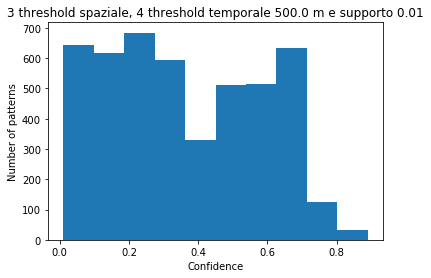

In [704]:
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Number of patterns')
plt.title(f'{maxDelta} threshold spaziale, {window_size} threshold temporale {th*1000} m e supporto {support}')
plt.savefig(img_support)
plt.show()

In [705]:
# #how many min, max, avg items there are
# num_items=0
# num_freq_items=0
# min_items=sys.maxsize
# max_items=0
# avg_items=0

# num_freq_window=0
# tot_window=0
# num_patterns=0
# min_window=sys.maxsize
# max_window=0
# avg_window=0
# flag_vuota=False
# flag_quasi_vuota=False

# list_vuota_quasi_vuota=[]

# for key in voc_supports.keys():
#     flag_vuota=False
#     flag_quasi_vuota=False    
#     string=''
    
#     #statistics for the windows
#     if '-' in key:
#         patterns=len(key.split('-'))
#         tot_window+=patterns      
#     else:
#         tot_window+=1
#         patterns=1
#     num_patterns+=1
    
#     #statistics for the ìtems
#     if ('-' in key and ',' in key):
#         new_key=key       
#         new_key=new_key.replace(',', '-')               
#         items=new_key.split('-')
#         for el in items:
#             string+=el.split('_')[0]
#             if el.split('_')[0].startswith('Vuota') and flag_vuota==False:
#                 flag_vuota=True
#             elif el.split('_')[0].startswith('QuasiVuota') and flag_quasi_vuota==False:
#                 flag_quasi_vuota=True
      
       
#     elif ('-' in key):
#         items=key.split('-')
#         for el in items:
#             string+=el.split('_')[0]
#             if el.split('_')[0].startswith('Vuota') and flag_vuota==False:
#                 flag_vuota=True
#             elif el.split('_')[0].startswith('QuasiVuota') and flag_quasi_vuota==False:
#                 flag_quasi_vuota=True
       
#     elif ( ',' in key):
#         items=key.split(',')
#         for el in items:
#             string+=el.split('_')[0]
#             if el.split('_')[0].startswith('Vuota') and flag_vuota==False:
#                 flag_vuota=True
#             elif el.split('_')[0].startswith('QuasiVuota') and flag_quasi_vuota==False:
#                 flag_quasi_vuota=True
      
#     else:
#         items=list(key)
#         for el in items:
#             string+=el.split('_')[0]
#             if el.split('_')[0].startswith('Vuota') and flag_vuota==False:
#                 flag_vuota=True
#             elif el.split('_')[0].startswith('QuasiVuota') and flag_quasi_vuota==False:
#                 flag_quasi_vuota=True
#     if (flag_quasi_vuota==True and flag_vuota==True): 
#         key_list=[]            
#         for e in key.split('-'):
#             key_list.append([e])
#         list_vuota_quasi_vuota.append([[key_list], [voc_supports[key]]])

#     q_items=len(items) 
#     if min_items>q_items:
#         min_items=q_items
#     if max_items<q_items:
#         max_items=q_items
#     freq=int(voc_supports[key].split('-')[1])
#     num_items+=freq 
#     num_freq_items+=freq*q_items
    
#     if min_window> patterns:
#         min_window=patterns
#     if max_window<patterns:
#         max_window=patterns    
#     num_freq_window+=freq*patterns  

# avg_window=0
# if num_items!=0:
#     avg_items=float(num_freq_items)/float(num_items)    
#     print(f'The average number of items is: {avg_items}')    
#     avg_window=float(num_freq_window)/ float(num_items)
#     print(f'The average number of windows is: {avg_window}')
# else:
#     print(f'The average number of windows is: {avg_window}')

# if min_items>1000:
#     min_items=0
#     min_window=0
# print(f'The minimum number of items is: {min_items}')
# print(f'The maximum number of items is: {max_items}')
# print(f'The minimum number of windows is: {min_window}')
# print(f'The maximum number of windows is: {max_window}')

In [706]:
# print('FILTER PATTERNS WITH AT LEAST 1 EVENT QUASI VUOTA AND 1 EVENT VUOTA ')

In [707]:
# # output_file2='results_1000_0_QuasiVuota_Vuota_ordered_by_confidence.txt'
# file2 = open(output_file2, "w")

In [708]:
# lung_vuota_quasivuota=0
# if len(list_vuota_quasi_vuota)!=0:
#     df_supports=sc.parallelize(list_vuota_quasi_vuota).toDF().withColumnRenamed('_1','sequence')
#     df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
#     lung_vuota_quasivuota=df_supports.count() 


In [709]:
# file2.write('Pattern, Confidence-Frequence'+'\n')
# file2.write(f'Total number of input patterns: {len(list_vuota_quasi_vuota)}'+'\n')
# if len(list_vuota_quasi_vuota)!=0:
#     for el in list_vuota_quasi_vuota:
#         #print(el)
#         file2.write(str(el)+'\n')
# file2.close()

In [710]:
# # output_file5='results_1000_0_QuasiVuota_Vuota_ordered_by_support.txt'
# file5 = open(output_file5, "w")

In [711]:
# #order list fist by support an then by confidence
# list_vuota_quasi_vuota_ordered_by_support = sorted(list_vuota_quasi_vuota,
#                                                    key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
#                                                    reverse=True)

In [712]:
# file5.write('Pattern, Confidence-Frequence'+'\n')
# file5.write(f'Total number of input patterns: {len(list_vuota_quasi_vuota_ordered_by_support)}'+'\n')
# if len(list_vuota_quasi_vuota_ordered_by_support)!=0:
#     for el in list_vuota_quasi_vuota_ordered_by_support:
#         #print(el)
#         file5.write(str(el)+'\n')
# file5.close()

In [713]:
# print('FILTER PATTERNS WITH AT LEAST 1 T0, DELTA S=0 AND AT LEAST 1 PATTERN WITH AT LEAST 1 PATTERN WITH DELTA S DIFFERENT FROM 0 AND DELTA T DIFFERENT FROM 0')

In [714]:
# list_influenze=[]
# for el in voc_supports.keys():
#     delta_spaziale=False
#     if ('-' in el):
#         all_windows_list=el.split('-')
#         if ('T0_0' in all_windows_list[0] ):
#             for cons_window in all_windows_list[1::]:
#                 if ',' in cons_window:
#                     for item in cons_window.split(','):                       
#                         act_delta=int(item.split('_')[2])
#                         if act_delta!=0:
#                             delta_spaziale=True
#     if delta_spaziale==True:        
#         key_list=[]            
#         for e in el.split('-'):
#             key_list.append([e])
#         list_influenze.append([[key_list], [voc_supports[el]]])

In [715]:
# # output_file3='results_1000_0_diff_delta_ordered_by_confidence.txt'
# file3 = open(output_file3, "w")

In [716]:
# lung_different_time_space=0
# if len(list_influenze)!=0:
#     df_supports=sc.parallelize(list_influenze).toDF().withColumnRenamed('_1','sequence')
#     df_supports=df_supports.withColumnRenamed('_2','confidence-freq')
#     lung_different_time_space=df_supports.count() 
#     #df_supports.show(lung_different_time_space,False)
#     #print(lung_different_time_space)

In [717]:
# file3.write('Pattern, Confidence-Frequence'+'\n')
# file3.write(f'Total number of input patterns: {len(list_influenze)}'+'\n')
# if len(list_influenze)!=0:
#     for el in list_influenze:       
#         file3.write(str(el)+'\n')
# file3.close()

In [718]:
# # output_file6='results_1000_0_diff_delta_ordered_by_support.txt'
# file6 = open(output_file6, "w")

In [719]:
# #order list first by support and then by confidence
# list_influenze_ordered_by_support = sorted(list_influenze,
#                                            key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
#                                            reverse=True)

In [720]:
# file6.write('Pattern, Confidence-Frequence'+'\n')
# file6.write(f'Total number of input patterns: {len(list_influenze_ordered_by_support)}'+'\n')
# if len(list_influenze_ordered_by_support)!=0:
#     for el in list_influenze_ordered_by_support:       
#         file6.write(str(el)+'\n')
# file6.close()

In [721]:
# print(f'The number of patterns in the pre-filter is: {len_prefix}')

In [722]:
# print(f'The number of items after the filter with at least 2 windows and at least a T0 and delta 0 is: {len(voc_supports)}')

In [723]:
# print('STATISTICS about sequences with at least 2 windows_T0_delta0')
# print(f'The average number of windows is: {avg_window}')
# print(f'The minimum number of windows is: {min_window}')
# print(f'The maximum number of windows is: {max_window}')
# print(f'The average number of items is: {avg_items}')
# print(f'The minimum number of items is: {min_items}')
# print(f'The maximum number of items is: {max_items}')

In [724]:
# print(f'The number of patterns in which there is at least one item that repeats within a window is: {repeated_el_window} ')

In [725]:
# print(f'The number of patterns with at least 1 event QuasiVuota and 1 event Vuota is: {lung_vuota_quasivuota}')

In [726]:
#  print(f'The number of patterns with at least 1 T0, DELTA S=0 and at least 1 pattern with at least 1 pattern with DELTA S different from 0 and DELTA T different from 0 is: {lung_different_time_space}')

In [727]:
end = time.time()
print(f'The time of execution is: {end-start} s')

The time of execution is: 372.64233660697937 s
